In [13]:
import json, os, warnings
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape

# Visualization of location data
This notebook displays the location of current restaurants in Vancouver, BC, Canada in 2019, as well as the location of restaurant openings and closings. The data is overlaid on top of neighborhood separations, with the five neighborhoods with the most restaurants highlighted.

In [70]:
license_data = {}
years = [13,14,15,16,17,18,19]
for year in years:
    with open(f'data/licenses_20{year}.txt', 'r') as infile:
        loaded_text = json.load(infile)
    records = [record['fields'] for record in json.loads(loaded_text)]
    idx = [record['recordid'] for record in json.loads(loaded_text)]
    license_data[year] = pd.DataFrame(records, index=idx)
    
restaurant_coordinates_2018 =[point['coordinates'] for point in license_data[18][license_data[18]['businesstype'].str.contains('restaurant', case=False).fillna(False)]['geom'].dropna()]
restaurant_coordinates_2019 =[point['coordinates'] for point in license_data[19][license_data[19]['businesstype'].str.contains('restaurant', case=False).fillna(False)]['geom'].dropna()]
closed = []
for point in restaurant_coordinates_2018:
    if point not in restaurant_coordinates_2019: closed.append(point)
opened = []
for point in restaurant_coordinates_2019:
    if point not in restaurant_coordinates_2018: opened.append(point)
        
opened_points = gpd.GeoSeries(gpd.points_from_xy(np.array(opened).T[0],np.array(opened).T[1]))
opened_points = opened_points.set_crs("EPSG:4326")
closed_points = gpd.GeoSeries(gpd.points_from_xy(np.array(closed).T[0],np.array(closed).T[1]))
closed_points = closed_points.set_crs("EPSG:4326")
        
changes = []
for year in years:
    data_old = license_data[years[0]][license_data[years[0]].businesstype.str.contains('restaurant', case=False)].groupby('localarea')['status'].value_counts().unstack().fillna(0)['Issued']#[areas]
    data_new = license_data[year][license_data[year].businesstype.str.contains('restaurant', case=False)].groupby('localarea')['status'].value_counts().unstack().fillna(0)['Issued']#[areas]
    changes.append((data_new-data_old))

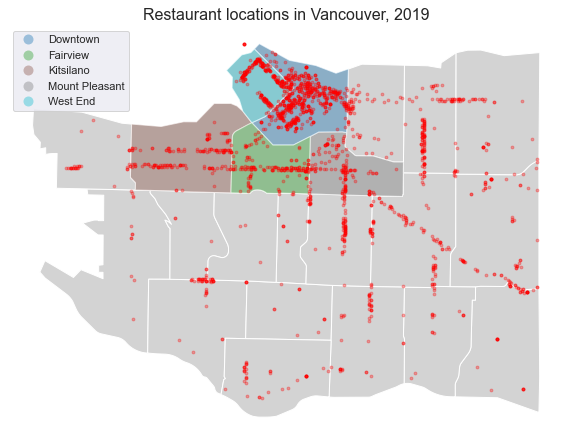

In [54]:
map_df = gpd.read_file('data/local-area-boundary.shp')
map_top5 = map_df[map_df['name'].str.contains(r'(kits)|(west end)|(downtown)|(fairview)|(mount pleasant)', case=False, regex=True)]

restaurant_coords = gpd.GeoDataFrame(license_data[19][license_data[19].businesstype.str.contains('restaurant', case=False)]['geom'].dropna().apply(shape)).set_geometry('geom')
restaurant_coords = restaurant_coords.set_crs("EPSG:4326")

plt.rcParams["figure.figsize"]=(10,10)
base = map_df.plot(alpha=1,color='lightgrey');
map_top5.plot(ax=base, column='name', legend=True, alpha=0.4);
restaurant_coords.plot(ax=base, color='red',alpha=0.3,markersize=8.,marker='o');
plt.grid(False);
plt.axis('off');
plt.title('Restaurant locations in Vancouver, 2019', fontsize=16);

Much of the municipal data available is easily sorted by neighborhood. However, it's clear that classifying restaurants by neighborhoods is not very efficient. In fact, because many neighborhood boundaries are defined by main streets, many restaurant clusters straddle boundaries. Nonetheless, geographic distribution should be able to tell us a lot about restaurant success. For example, consider the change in the number of restaurants in the highlighted neighborhoords:

Text(0, 0.5, 'Number compared to 2013')

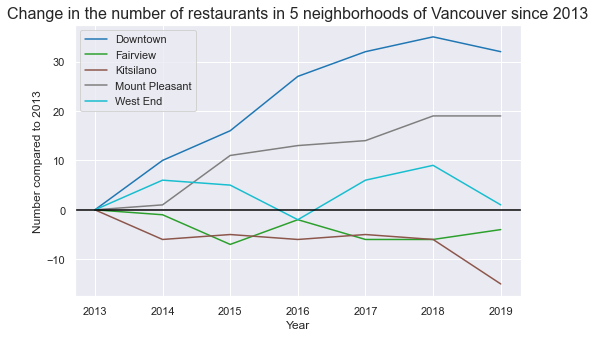

In [69]:
top5_areas = ['Downtown','Fairview','Kitsilano','Mount Pleasant','West End']
colors = ['tab:blue', 'tab:green', 'tab:brown', 'tab:grey', 'tab:cyan']
plt.rcParams["figure.figsize"]=(8,5)
for color, area in zip(colors, top5_areas):
    plt.plot(2000+np.array(years),pd.concat(changes)[area], color=color, label=area)
plt.legend()
plt.grid(True)
plt.axis('on')
plt.axhline(0,color='black')
plt.title('Change in the number of restaurants in 5 neighborhoods of Vancouver since 2013', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Number compared to 2013')

We can see, for example, that the evolution of restaurants Downtown and in the Kitsilano neighborhood was very different over the last six years. Refering to the map above, the clusters of restaurants in those two areas appear fairly disconnected (compared to restaurants in other pairs of neighborhoods). This highlights that if we can consider separate clusters, we can analyze the chances of success of a restaurant better. Of course, we have access to data about individual openings and closings, as shown in the map below for 2019

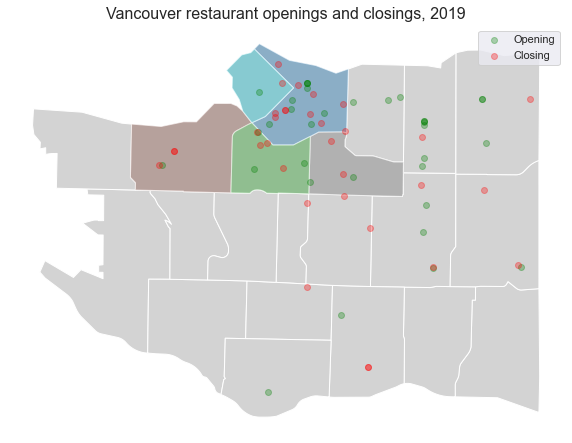

In [75]:
plt.rcParams["figure.figsize"]=(10,10)
base = map_df.plot(alpha=1,color='lightgrey');
map_top5.plot(ax=base, column='name', legend=True, alpha=0.4);
opened_points.plot(ax=base, color='green',alpha=0.3, label='Opening');
closed_points.plot(ax=base, color='red',alpha=0.3, label='Closing');
plt.grid(False);
plt.axis('off');
plt.title('Vancouver restaurant openings and closings, 2019', fontsize=16);
plt.legend();